In [1]:
#!/usr/bin/env python 

from keras.layers import Input, Dense
from keras.models import Model 
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import os
import sys

from PIL import Image 
import glob

# my utility module for loading imgs
from util import utility

# s'il te plait pour gpu soutien
'''
RUN KERAS
THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32 python imdb_cnn.py
'''
jpgfile = '/Users/nolanlem/Documents/PROJECTS/pro-arts-show/faces/CAS-PEAL-R1/RENDERS-JPG/mypic.jpg'



Using Theano backend.
//anaconda/lib/python2.7/site-packages/theano/configdefaults.py:1818: UserWarning: Theano does not recognise this flag: deice
  warnings.warn('Theano does not recognise this flag: {0}'.format(key))


In [2]:
from util import utility

In [2]:
# this function is in utility now 
# function to extract jpgs from sourcedir to numpy array for training
# def getImages(sourcedir): 
#     imgdata = np.zeros((1,360*360))
#     for img in glob.glob(sourcedir + "*.jpg"):
#         sourceimg = Image.open(img)
#         sourceimg = np.asarray(sourceimg, dtype='float32')
#         sourceimg = sourceimg/255.
#         sourceimg = sourceimg.reshape((1,sourceimg.shape[0]*sourceimg.shape[1])) 
#         imgdata = np.vstack((imgdata,sourceimg)) 
#     imgdata = imgdata[1:] # remove first entry of zeros
#     return imgdata 



In [430]:
# this is the size of our encoded representation 
# make the CNN graph
#from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D


INPUT_SHAPE = (1000, 300, 3)
input_img = Input(shape=INPUT_SHAPE)  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoder = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoder)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
print autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        (None, 1000, 300, 3)      0         
_________________________________________________________________
conv2d_288 (Conv2D)          (None, 1000, 300, 16)     448       
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 500, 150, 16)      0         
_________________________________________________________________
conv2d_289 (Conv2D)          (None, 500, 150, 8)       1160      
_________________________________________________________________
encoder (MaxPooling2D)       (None, 250, 75, 8)        0         
_________________________________________________________________
conv2d_290 (Conv2D)          (None, 250, 75, 8)        584       
_________________________________________________________________
up_sampling2d_118 (UpSamplin (None, 500, 150, 8)       0         
__________

In [5]:
# x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# encoder = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

# # at this point the representation is (4, 4, 8) i.e. 128-dimensional

# x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoder)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(16, (3, 3), activation='relu')(x)
# x = UpSampling2D((2, 2))(x)
# decoder = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

AttributeError: 'TensorVariable' object has no attribute 'summary'

In [431]:
# get the images loaded 
thedir = '/Volumes/nolanHD/pro-arts-show/fingers/data/resized-fingers/'
thedir = '/Volumes/nolanHD/pro-arts-show/fingers/data/trial-fingers/'

x_train = getImages(thedir)
print 'done'
test_end = int(len(x_train)*0.9)
x_test = x_train[test_end:]
x_train = x_train[:test_end]

reading files from '/Volumes/nolanHD/pro-arts-show/fingers/data/trial-fingers/'
files are of '.bmp' type
 Reading ---> /Volumes/nolanHD/pro-arts-show/fingers/data/trial-fingers/100_1.bmp(1, 1000, 300, 3)
(2, 1000, 300, 3)
 Reading ---> /Volumes/nolanHD/pro-arts-show/fingers/data/trial-fingers/100_2.bmp(1, 1000, 300, 3)
(3, 1000, 300, 3)
 Reading ---> /Volumes/nolanHD/pro-arts-show/fingers/data/trial-fingers/100_3.bmp(1, 1000, 300, 3)
(4, 1000, 300, 3)
 Reading ---> /Volumes/nolanHD/pro-arts-show/fingers/data/trial-fingers/100_4.bmp(1, 1000, 300, 3)
(5, 1000, 300, 3)
 Reading ---> /Volumes/nolanHD/pro-arts-show/fingers/data/trial-fingers/100_5.bmp(1, 1000, 300, 3)
(6, 1000, 300, 3)
...finished
done


In [429]:
# REVISED function to extract jpgs from sourcedir to numpy array for training
#
def getImages(sourcedir, crop=False):
    if os.path.isdir(sourcedir) == True: 
        print 'reading files from %r' %(sourcedir)
        imgdata = np.zeros((1,1000,300,3))
        basename = os.path.basename(glob.glob(sourcedir + '/*')[1])
        imgformat = os.path.splitext(basename)[1]
        print 'files are of %r type' %(imgformat)
        for img in glob.glob(sourcedir + "*" + imgformat):
            sys.stdout.write('\r Reading ---> %s' %img)
            sys.stdout.flush()
            sourceimg = mpimg.imread(img)
            sourceimg = np.array(sourceimg, dtype='float32')
            sourceimg = sourceimg/255.0

            sourceimg = np.reshape(sourceimg,(1,sourceimg.shape[0],sourceimg.shape[1],sourceimg.shape[2])) 
            print sourceimg.shape
            imgdata = np.vstack((imgdata,sourceimg))
            print imgdata.shape
        imgdata = imgdata[1:] # remove first entry of zeros
    else:
        print '%r not a dir' %(sourcedir)
        imgdata = 0 
    print '...finished'
    return imgdata 

In [441]:
from keras.callbacks import ModelCheckpoint

# train ae for N epochs 
numepoch = 500
modelfn = 'fingers-ae-' + str(numepoch) + '-epoch' # model name
checkptname = modelfn + '.hdf5'
#checkptname_ = '/Users/nolanlem/Google\ Drive/ae-models/' + checkptname
modelname = './models/' + checkptname
#checkpointer = ModelCheckpoint(filepath=checkptname_, verbose=1, save_best_only=True, save_weights_only=False)


# TRAIN THE MODEL
autoencoder.fit(x_train, x_train, epochs=numepoch, 
                batch_size=4, 
                shuffle=True,
                validation_data=(x_test,x_test),
                #callbacks=[checkpointer]
               ) 

# save the model 
from keras.models import load_model

# autoencoder.save(modelname) 
#encode and decode some digits 
# note that we take them from the test set 
#encoded_imgs = autoencoder.predict(x_test) 
#decoded_imgs = decoder.predict(encoded_imgs) 

print 'done, now run prediction module below...'

Train on 4 samples, validate on 1 samples
Epoch 1/500
4/4 [==============================] - 3s - loss: 0.6937 - val_loss: 0.6932
Epoch 2/500
4/4 [==============================] - 3s - loss: 0.6934 - val_loss: 0.6929
Epoch 3/500
4/4 [==============================] - 3s - loss: 0.6930 - val_loss: 0.6926
Epoch 4/500
4/4 [==============================] - 3s - loss: 0.6927 - val_loss: 0.6922
Epoch 5/500
4/4 [==============================] - 3s - loss: 0.6924 - val_loss: 0.6919
Epoch 6/500
4/4 [==============================] - 3s - loss: 0.6920 - val_loss: 0.6915
Epoch 7/500
4/4 [==============================] - 3s - loss: 0.6916 - val_loss: 0.6909
Epoch 8/500
4/4 [==============================] - 3s - loss: 0.6910 - val_loss: 0.6902
Epoch 9/500
4/4 [==============================] - 3s - loss: 0.6903 - val_loss: 0.6897
Epoch 10/500
4/4 [==============================] - 3s - loss: 0.6899 - val_loss: 0.6891
Epoch 11/500
4/4 [==============================] - 3s - loss: 0.6893 - val_l

4/4 [==============================] - 3s - loss: 0.5615 - val_loss: 0.5602
Epoch 93/500
4/4 [==============================] - 3s - loss: 0.5618 - val_loss: 0.5603
Epoch 94/500
4/4 [==============================] - 3s - loss: 0.5615 - val_loss: 0.5600
Epoch 95/500
4/4 [==============================] - 3s - loss: 0.5617 - val_loss: 0.5602
Epoch 96/500
4/4 [==============================] - 3s - loss: 0.5615 - val_loss: 0.5601
Epoch 97/500
4/4 [==============================] - 3s - loss: 0.5618 - val_loss: 0.5602
Epoch 98/500
4/4 [==============================] - 3s - loss: 0.5614 - val_loss: 0.5600
Epoch 99/500
4/4 [==============================] - 3s - loss: 0.5616 - val_loss: 0.5602
Epoch 100/500
4/4 [==============================] - 3s - loss: 0.5614 - val_loss: 0.5601
Epoch 101/500
4/4 [==============================] - 3s - loss: 0.5618 - val_loss: 0.5602
Epoch 102/500
4/4 [==============================] - 3s - loss: 0.5614 - val_loss: 0.5599
Epoch 103/500
4/4 [============

4/4 [==============================] - 3s - loss: 0.5609 - val_loss: 0.5594
Epoch 184/500
4/4 [==============================] - 3s - loss: 0.5607 - val_loss: 0.5594
Epoch 185/500
4/4 [==============================] - 3s - loss: 0.5611 - val_loss: 0.5594
Epoch 186/500
4/4 [==============================] - 3s - loss: 0.5607 - val_loss: 0.5593
Epoch 187/500
4/4 [==============================] - 3s - loss: 0.5609 - val_loss: 0.5594
Epoch 188/500
4/4 [==============================] - 3s - loss: 0.5607 - val_loss: 0.5593
Epoch 189/500
4/4 [==============================] - 3s - loss: 0.5610 - val_loss: 0.5594
Epoch 190/500
4/4 [==============================] - 3s - loss: 0.5607 - val_loss: 0.5592
Epoch 191/500
4/4 [==============================] - 3s - loss: 0.5609 - val_loss: 0.5593
Epoch 192/500
4/4 [==============================] - 3s - loss: 0.5606 - val_loss: 0.5593
Epoch 193/500
4/4 [==============================] - 3s - loss: 0.5610 - val_loss: 0.5593
Epoch 194/500
4/4 [=====

4/4 [==============================] - 3s - loss: 0.5603 - val_loss: 0.5591
Epoch 275/500
4/4 [==============================] - 3s - loss: 0.5608 - val_loss: 0.5589
Epoch 276/500
4/4 [==============================] - 3s - loss: 0.5602 - val_loss: 0.5588
Epoch 277/500
4/4 [==============================] - 3s - loss: 0.5605 - val_loss: 0.5588
Epoch 278/500
4/4 [==============================] - 3s - loss: 0.5602 - val_loss: 0.5590
Epoch 279/500
4/4 [==============================] - 3s - loss: 0.5607 - val_loss: 0.5589
Epoch 280/500
4/4 [==============================] - 3s - loss: 0.5602 - val_loss: 0.5589
Epoch 281/500
4/4 [==============================] - 3s - loss: 0.5606 - val_loss: 0.5589
Epoch 282/500
4/4 [==============================] - 3s - loss: 0.5602 - val_loss: 0.5590
Epoch 283/500
4/4 [==============================] - 3s - loss: 0.5607 - val_loss: 0.5588
Epoch 284/500
4/4 [==============================] - 3s - loss: 0.5602 - val_loss: 0.5588
Epoch 285/500
4/4 [=====

4/4 [==============================] - 3s - loss: 0.5602 - val_loss: 0.5584
Epoch 366/500
4/4 [==============================] - 3s - loss: 0.5598 - val_loss: 0.5586
Epoch 367/500
4/4 [==============================] - 3s - loss: 0.5603 - val_loss: 0.5584
Epoch 368/500
4/4 [==============================] - 3s - loss: 0.5598 - val_loss: 0.5585
Epoch 369/500
4/4 [==============================] - 3s - loss: 0.5602 - val_loss: 0.5583
Epoch 370/500
4/4 [==============================] - 3s - loss: 0.5597 - val_loss: 0.5582
Epoch 371/500
4/4 [==============================] - 3s - loss: 0.5599 - val_loss: 0.5582
Epoch 372/500
4/4 [==============================] - 3s - loss: 0.5596 - val_loss: 0.5582
Epoch 373/500
4/4 [==============================] - 3s - loss: 0.5599 - val_loss: 0.5582
Epoch 374/500
4/4 [==============================] - 3s - loss: 0.5596 - val_loss: 0.5583
Epoch 375/500
4/4 [==============================] - 3s - loss: 0.5600 - val_loss: 0.5583
Epoch 376/500
4/4 [=====

4/4 [==============================] - 3s - loss: 0.5595 - val_loss: 0.5580
Epoch 457/500
4/4 [==============================] - 3s - loss: 0.5597 - val_loss: 0.5581
Epoch 458/500
4/4 [==============================] - 3s - loss: 0.5595 - val_loss: 0.5580
Epoch 459/500
4/4 [==============================] - 3s - loss: 0.5597 - val_loss: 0.5581
Epoch 460/500
4/4 [==============================] - 3s - loss: 0.5595 - val_loss: 0.5580
Epoch 461/500
4/4 [==============================] - 3s - loss: 0.5597 - val_loss: 0.5580
Epoch 462/500
4/4 [==============================] - 3s - loss: 0.5595 - val_loss: 0.5580
Epoch 463/500
4/4 [==============================] - 3s - loss: 0.5597 - val_loss: 0.5580
Epoch 464/500
4/4 [==============================] - 3s - loss: 0.5595 - val_loss: 0.5580
Epoch 465/500
4/4 [==============================] - 3s - loss: 0.5596 - val_loss: 0.5580
Epoch 466/500
4/4 [==============================] - 3s - loss: 0.5594 - val_loss: 0.5580
Epoch 467/500
4/4 [=====

(1, 1000, 300, 3)
(1000, 300, 3)


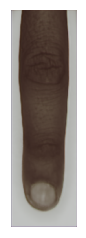

In [446]:
# MAKE PREDICTION  and RECONSTRUCT
encoded_imgs = autoencoder.predict(x_test) 

print encoded_imgs.shape
theimg = encoded_imgs[0]
#theimg = x_train[0]
print theimg.shape
plt.imshow(theimg)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')
plt.show()

(1000, 300, 3)


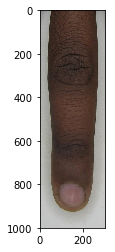

In [444]:
# ORIGINAL
theimg = x_test[0]
#theimg = x_train[0]
print theimg.shape
plt.imshow(theimg)
plt.show()

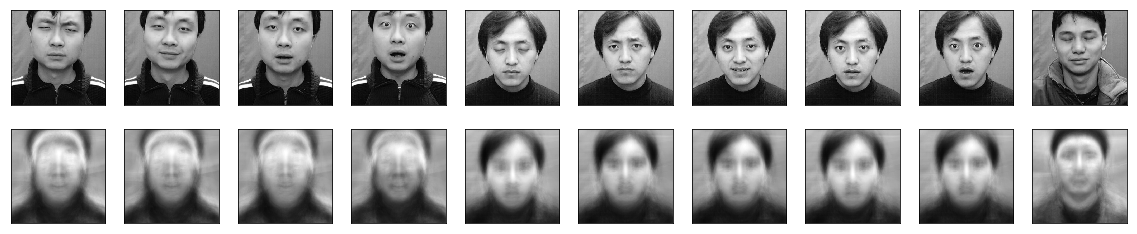

In [22]:
import matplotlib.pyplot as plt 
 
n = 10 
width = 360
plt.figure(figsize=(20,4)) 
for i in range(n):
    ax = plt.subplot(2,n,i+1) 
    plt.imshow(x_test[i].reshape(width,width)) 
    plt.gray() 
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False) 

    #display reconstruction 
    ax = plt.subplot(2,n,i+1+n) 
    plt.imshow(decoded_imgs[i].reshape(width,width)) 
    plt.gray() 
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False)

plt.show() 

In [30]:
expressionsdir = './individual-renders/Expressions/'

width = 360
#plt.figure(figsize=(20,4)) # (w,h) tuple in inches
mainfig = plt.figure(figsize=(40,40)) # (40,40) this is 30.5 x 31 inches

n = 100
# w, rows and columns of grid 
w = int(np.sqrt(n))

for i in xrange(n):
    print "%r/%r" %(i,n)
    
    ax1 = mainfig.add_subplot(w,w, i+1)
    theimg = decoded_imgs[i].reshape(width,width) 
    theimg = theimg[:,:-1] 
    ax1.imshow(theimg) 
    ax1.get_xaxis().set_visible(False) 
    ax1.get_yaxis().set_visible(False)
    ax1.axis('off')

    # save individual portraits
#     indfig = plt.figure(figsize=(12,12)) # 1'x1'
#     ax2 = indfig.gca()
#     ax2.set_axis_off()
#     theimg = decoded_imgs[i].reshape(width,width) 
#     theimg = theimg[:,:-1] # this gets rid of that right border that is a feature of the source imgs
#     ax2.imshow(theimg)
#     ax2.get_xaxis().set_visible(False) 
#     ax2.get_yaxis().set_visible(False)
#     #ax2.axis('off')
#     indfig.tight_layout()
    #indfig.savefig(expressionsdir + str(i) +".tif", bbox_inches='tight', dpi=300)
#plt.show()
plt.savefig('500-expressions-ae.tif', bbox_inches='tight', dpi=300)
plt.close()

0/100
1/100
2/100
3/100
4/100
5/100
6/100
7/100
8/100
9/100
10/100
11/100
12/100
13/100
14/100
15/100
16/100
17/100
18/100
19/100
20/100
21/100
22/100
23/100
24/100
25/100
26/100
27/100
28/100
29/100
30/100
31/100
32/100
33/100
34/100
35/100
36/100
37/100
38/100
39/100
40/100
41/100
42/100
43/100
44/100
45/100
46/100
47/100
48/100
49/100
50/100
51/100
52/100
53/100
54/100
55/100
56/100
57/100
58/100
59/100
60/100
61/100
62/100
63/100
64/100
65/100
66/100
67/100
68/100
69/100
70/100
71/100
72/100
73/100
74/100
75/100
76/100
77/100
78/100
79/100
80/100
81/100
82/100
83/100
84/100
85/100
86/100
87/100
88/100
89/100
90/100
91/100
92/100
93/100
94/100
95/100
96/100
97/100
98/100
99/100


NameError: global name 'xtestset' is not defined

In [39]:
def blendfaces(blendeddir, x_testset, decodedimgs, opacity=0.9):
	'''
	USAGE: provide blendeddir : directory to store blended and test_set composites

	x_testset is array of images to overlay onto learned decodedimgs
    conditions: x_testset > decodedimgs 
	'''
	try: 
		os.mkdir(blendeddir)
	except OSError:
		'%r already exists! ok' %(blendeddir)

	# get number of images in blendeddir 
	#numimg = glob.glob(blendeddir + '/*')	
	#print 'there are %r imgs in %r'%(numimg, blendeddir) 

	for i in range(0, len(x_testset), 1):
		layer1 = Image.fromarray(255.*x_testset[i].reshape((360,360))) 
	 	layer2 = Image.fromarray(255.*decodedimgs[i].reshape((360,360)))
		layer1 =layer1.convert('RGBA') 
		layer2 =layer2.convert('RGBA')
		blendedimg = Image.blend(layer1,layer2,alpha=opacity)
		croppedimg = blendedimg.crop((0,0,359,360)) # take out right black edge
		print 'saving file as %r' %(blendeddir + str(i) + '.tif')
		croppedimg.save(blendeddir + str(i) + '.tif')

In [ ]:
def getImages(sourcedir, crop=False):
    if os.path.isdir(sourcedir) == True: 
        #print os.path.isdir(sourcedir)
        print 'reading files from %r' %(sourcedir)
        imgdata = np.zeros((1,3,300,1000))
        basename = os.path.basename(glob.glob(sourcedir + '/*')[1])
        imgformat = os.path.splitext(basename)[1]
        print 'files are of %r type' %(imgformat)
        for img in glob.glob(sourcedir + "*" + imgformat):
            sys.stdout.write('\r Reading ---> %s' %img)
            sys.stdout.flush()
            sourceimg = Image.open(img)
            width = sourceimg.size[0]
            height = sourceimg.size[1]
            print '\t', width, height
            if crop==True:
                print 'cropping'                
                sourceimg = sourceimg.crop((width-width, height-width-20,width,height-20))         
            sourceimg = np.asarray(sourceimg, dtype='float32')
            #print sourceimg.shape

            
            sourceimg = np.transpose(sourceimg)
            #print sourceimg.shape

            #sourceimg = sourceimg.reshape((1,sourceimg.shape[0]*sourceimg.shape[1]))
            sourceimg = sourceimg/255.
            sourceimg = np.reshape(sourceimg,(1,sourceimg.shape[0],sourceimg.shape[1],sourceimg.shape[2])) 
            print sourceimg.shape
            imgdata = np.vstack((imgdata,sourceimg))
            print imgdata.shape
        imgdata = imgdata[1:] # remove first entry of zeros
    else:
        print '%r not a dir' %(sourcedir)
        imgdata = 0 
    print '...finished'
    return imgdata 